# Amazon Fine Food Reviews Analysis

**Data Source:** [Kaggle - Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-review)

**EDA:** [NYC Data Science - Amazon Fine Foods Visualization](https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/)

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

- **Number of reviews:** 568,454
- **Number of users:** 256,059
- **Number of products:** 74,258
- **Timespan:** Oct 1999 - Oct 2012
- **Number of Attributes/Columns in data:** 10

**Attribute Information:**

- **Id**
- **ProductId** - unique identifier for the product
- **UserId** - unique identifier for the user
- **ProfileName**
- **HelpfulnessNumerator** - number of users who found the review helpful
- **HelpfulnessDenominator** - number of users who indicated whether they found the review helpful or not
- **Score** - rating between 1 and 5
- **Time** - timestamp for the review
- **Summary** - brief summary of the review
- **Text** - text of the review

**Objective:**  
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

**[Q] How to determine if a review is positive or negative?**

**[Ans]** We could use the Score/Rating. A rating of 4 or 5 could be considered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is neutral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


<h2> Reading Data </h2>

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.manifold import TSNE
from sklearn import datasets


from prettytable import PrettyTable  

import re
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
from gensim.models import Word2Vec

In [77]:
db_path = 'database.sqlite'  
conn = sqlite3.connect(db_path)

query = "SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000"
filtered_data = pd.read_sql_query(query, conn)

In [79]:
def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


<h2>Exploratory Data Analysis(EDA)</h2>

<h3>Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:</h3>

In [81]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


wstr sort''

In [84]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId')
sorted_data.shape

(5000, 10)

In [86]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"})
final.shape

(4986, 10)

In [88]:
#Checking to see how much % of data still remains
(final['Id'].size)/(filtered_data['Id'].size)*100

99.72

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [91]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Id=44737 OR Id=64422
""", conn)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [93]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [95]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


Score
1    4178
0     808
Name: count, dtype: int64

<h2> Text Preprocessing.</h2>

<h3>Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags
2.Remove any punctuations or limited set of special characters like , or . or # etc.
3.Check if the word is made up of english letters and is not alpha-numeric
4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5.Convert the word to lowercase
6.Remove Stopwords
7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews</h3>

In [99]:
sent_0 = final['Text'].values[0]
print(sent_0)
print("-"*100)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("-"*100)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("-"*100)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("-"*100)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
----------------------------------------------------------------------------------------------------
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier t

In [101]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039

sent_0 = re.sub(r"http\S+", "", sent_0)
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [103]:
for sent in final['Text'].values:
    if(len(re.findall('<.*?>', sent))):
        print(sent)
        break;

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [105]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("-"*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("-"*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("-"*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
--------------------------------------------------
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
--------------------------------------------------
Wow.  So far, two two-star reviews. 

In [107]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [109]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [111]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039

sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [113]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039

sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [115]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [117]:
# Combining all the above stundents 
# tqdm is for printing the status bar
# https://gist.github.com/sebleier/554280

preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

  0%|          | 0/4986 [00:00<?, ?it/s]C:\Users\karti\AppData\Local\Temp\ipykernel_1952\3969704025.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentance = BeautifulSoup(sentance, 'lxml').get_text()
100%|██████████| 4986/4986 [00:01<00:00, 4707.99it/s]


In [119]:
preprocessed_reviews[4000]

'age even basic service no longer exists pleasantly surprised transaction actually came without hitch shipped time product good condition well done'

In [121]:
final['cleanedtext'] = preprocessed_reviews
print(final.head())

        Id   ProductId          UserId                   ProfileName  \
2546  2774  B00002NCJC  A196AJHU9EASJN                  Alex Chaffee   
2547  2775  B00002NCJC  A13RRPGE79XFFH                      reader48   
1145  1244  B00002Z754  A3B8RCEI0FXFI6                     B G Chase   
1146  1245  B00002Z754  A29Z5PI9BW2PU3                        Robbie   
2942  3204  B000084DVR  A1UGDJP1ZJWVPF  T. Moore "thoughtful reader"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2546                     0                       0      1  1282953600   
2547                     0                       0      1  1281052800   
1145                    10                      10      1   962236800   
1146                     7                       7      1   961718400   
2942                     1                       1      1  1177977600   

                             Summary  \
2546                   thirty bucks?   
2547                    Flies Begone   
1145  WO

<h2>Text Vectorization</h2>

<h3>BAG OF WORDS(BOW)</h3>

In [124]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:10])

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aahhhs' 'aback' 'abandon' 'abates' 'abbott' 'abby' 'abdominal'
 'abiding' 'ability']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


<h3>Bi-Grams and n-Grams.</h3>

In [127]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


<h3>TF-IDF</h3>

In [130]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('-'*100)
 
final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able find' 'able get' 'absolute' 'absolutely'
 'absolutely delicious' 'absolutely love' 'absolutely no' 'according']
----------------------------------------------------------------------------------------------------
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


<h3>Word2Vec</h3>

In [133]:
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

print(preprocessed_reviews[0])
print(list_of_sentance[0])

product available victor traps unreal course total fly genocide pretty stinky right nearby
['product', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'genocide', 'pretty', 'stinky', 'right', 'nearby']


In [135]:
w2v_model = Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)

In [137]:
print(w2v_model.wv.most_similar('taste'))
print('-'*100)
print(w2v_model.wv.most_similar('worst'))

[('like', 0.9938964247703552), ('flavor', 0.9881112575531006), ('strong', 0.9880453944206238), ('tastes', 0.9871933460235596), ('sweet', 0.983759880065918), ('bitter', 0.9716254472732544), ('really', 0.9691488742828369), ('cocoa', 0.9691051244735718), ('dark', 0.9685478806495667), ('chocolate', 0.9655482769012451)]
----------------------------------------------------------------------------------------------------
[('perhaps', 0.9979568123817444), ('served', 0.9978652596473694), ('start', 0.9978486895561218), ('turned', 0.997839093208313), ('beef', 0.99782794713974), ('double', 0.9977943301200867), ('clear', 0.9977646470069885), ('level', 0.9977645874023438), ('together', 0.9977623820304871), ('american', 0.9977177977561951)]


In [139]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['not', 'like', 'good', 'great', 'taste', 'one', 'product', 'would', 'flavor', 'love', 'coffee', 'food', 'chips', 'tea', 'no', 'really', 'get', 'best', 'much', 'amazon', 'use', 'time', 'buy', 'also', 'tried', 'little', 'find', 'make', 'price', 'better', 'bag', 'try', 'even', 'mix', 'well', 'chocolate', 'hot', 'eat', 'free', 'water', 'dog', 'first', 'made', 'could', 'found', 'used', 'bought', 'box', 'sugar', 'cup']


<h3>AVG W2V</h3>

In [142]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:02<00:00, 1916.21it/s]


4986
50


<h3>TFIDF weighted W2v</h3>

In [145]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [147]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:39<00:00, 125.84it/s]


In [149]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

4986
50


<h2>Applying TSNE</h2>

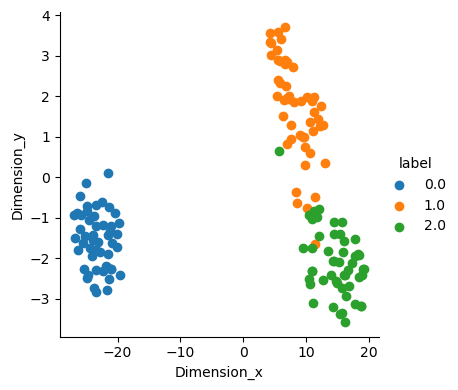

In [68]:
iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, random_state=0)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((X_embedding.T, y)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])

sns.FacetGrid(for_tsne_df, hue="label", height=4).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.show()

<h3>Applying TNSE on Text BOW vectors</h3>

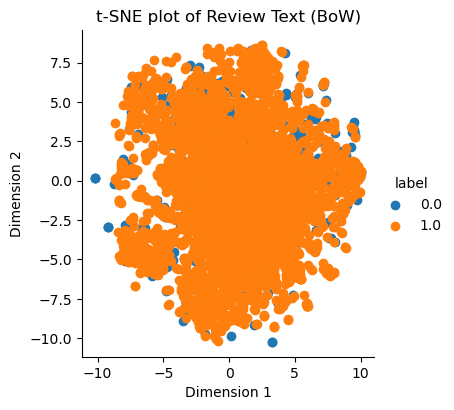

In [156]:
# Apply t-SNE to the BoW vectors
tsne = TSNE(n_components=2, random_state=0)
X_embedding = tsne.fit_transform(final_counts.toarray())

labels = final['Score']

# Combine the t-SNE coordinates with the labels
for_tsne = np.vstack((X_embedding.T, labels)).T

# Create a DataFrame for easy plotting
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'label'])

# Plot the t-SNE results using seaborn's FacetGrid
sns.FacetGrid(for_tsne_df, hue="label", height=4).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('t-SNE plot of Review Text (BoW)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

<h3>Applying TNSE on Text TFIDF vectors</h3>

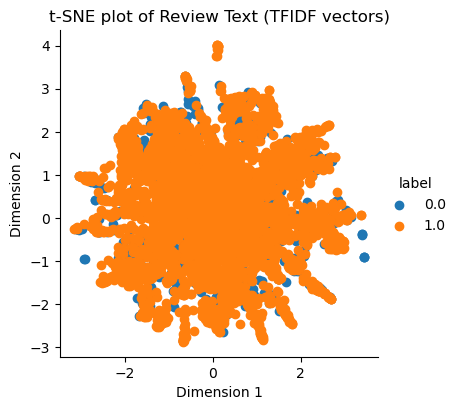

In [160]:
# Applying TNSE on Text TFIDF vectors
tsne = TSNE(n_components=2, random_state=0)
X_embedding = tsne.fit_transform(final_tf_idf.toarray())

labels = final['Score']

# Combine the t-SNE coordinates with the labels
for_tsne = np.vstack((X_embedding.T, labels)).T

# Create a DataFrame for easy plotting
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'label'])

# Plot the t-SNE results using seaborn's FacetGrid
sns.FacetGrid(for_tsne_df, hue="label", height=4).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('t-SNE plot of Review Text (TFIDF vectors)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

<h3> Applying TNSE on Text Avg W2V vectors</h3>

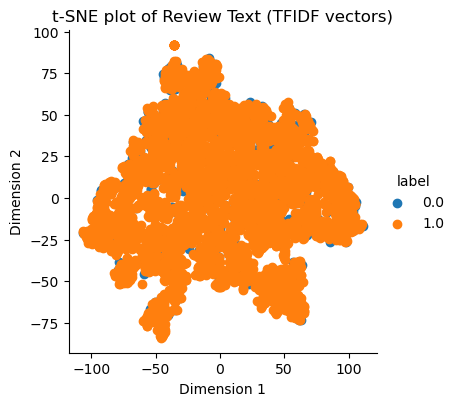

In [172]:
# Applying TNSE on Text Avg W2V vectors
sent_vectors = np.array(sent_vectors)

tsne = TSNE(n_components=2, random_state=0, n_iter=5000)
X_embedding = tsne.fit_transform(sent_vectors)

labels = final['Score'].values

# Combine the t-SNE coordinates with the labels
for_tsne = np.vstack((X_embedding.T, labels)).T

# Create a DataFrame for easy plotting
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'label'])

# Plot the t-SNE results using seaborn's FacetGrid
sns.FacetGrid(for_tsne_df, hue="label", height=4).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('t-SNE plot of Review Text (TFIDF vectors)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

<h3>Applying TNSE on Text TFIDF weighted W2V vectors</h3>

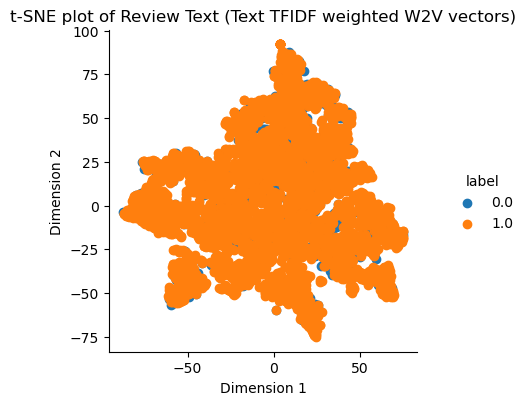

In [183]:
# Applying TNSE on Text Avg W2V vectors
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

tsne = TSNE(n_components=2, perplexity=40 ,random_state=1, n_iter=5000)
X_embedding = tsne.fit_transform(tfidf_sent_vectors)

labels = final['Score'].values

# Combine the t-SNE coordinates with the labels
for_tsne = np.vstack((X_embedding.T, labels)).T

# Create a DataFrame for easy plotting
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x', 'Dimension_y', 'label'])

# Plot the t-SNE results using seaborn's FacetGrid
sns.FacetGrid(for_tsne_df, hue="label", height=4).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title('t-SNE plot of Review Text (Text TFIDF weighted W2V vectors)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

<h2>Applying KNN brute force</h2>

<h3> Applying KNN brute force on BOW </h3>

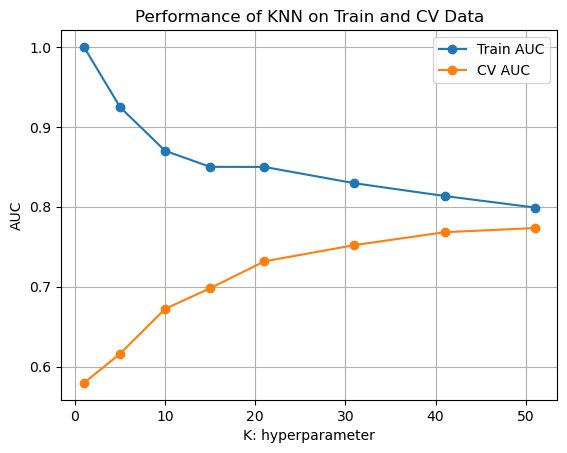

In [342]:
# Split the data first to avoid data leakage
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.33,random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,random_state=42)

# Vectorize the data
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)
X_cv_bow = count_vect.transform(X_cv)

# Apply KNN and evaluate using ROC-AUC
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs
    y_train_pred = neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred = neigh.predict_proba(X_cv_bow)[:,1]

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

# Plot the performance of the model on train and cross-validation data
plt.plot(K, train_auc, label='Train AUC', marker='o')
plt.plot(K, cv_auc, label='CV AUC', marker='o')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance of KNN on Train and CV Data")
plt.show()


The optimal number of neighbors is 51.
Test AUC for K=51: 0.7381347390214666
Train AUC for K=51: 0.7989465968141422


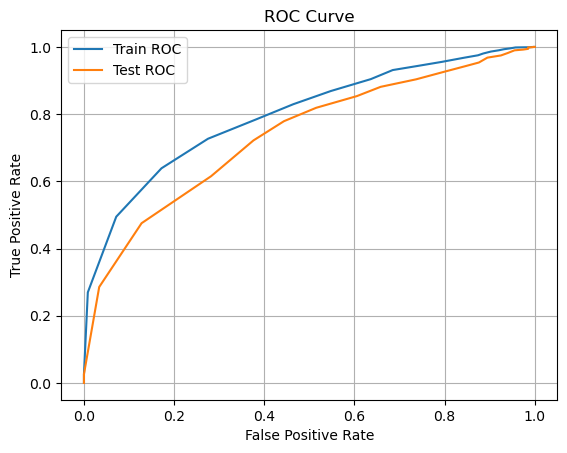

In [344]:
#best hyperparameter
optimal_k = K[cv_auc.index(max(cv_auc))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

# Train the model with the best hyperparameter
best_knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
best_knn.fit(X_train_bow, y_train)

# Predict and evaluate on test data
y_test_pred_prob = best_knn.predict_proba(X_test_bow)[:,1]
y_train_pred_prob = best_knn.predict_proba(X_train_bow)[:,1]

Test_auc = roc_auc_score(y_test, y_test_pred_prob)
Train_auc = roc_auc_score(y_train, y_train_pred_prob)

print(f'Test AUC for K={optimal_k}: {Test_auc}')
print(f'Train AUC for K={optimal_k}: {Train_auc}')

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()

Train confusion matrix
[[   1  348]
 [   0 1888]]
Test confusion matrix
[[   1  265]
 [   0 1380]]


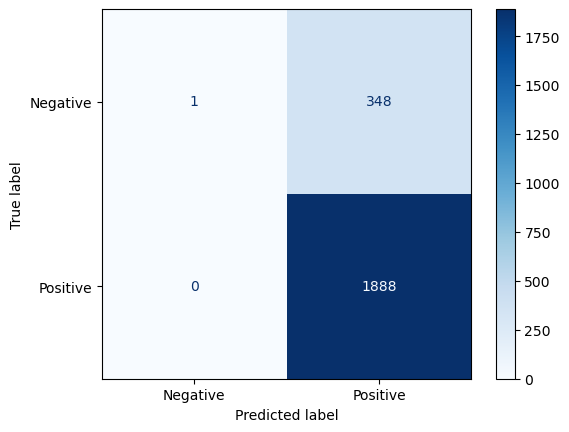

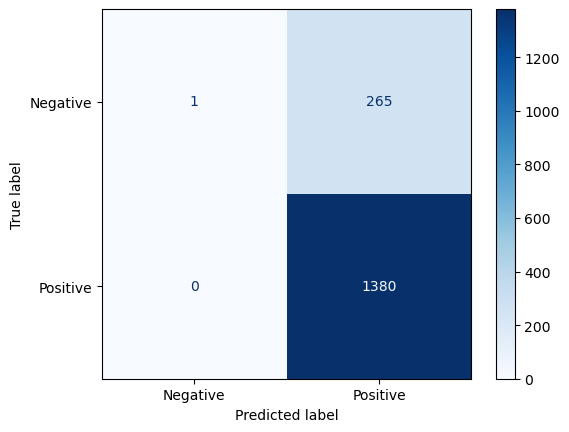

In [346]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, best_knn.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, best_knn.predict(X_test_bow)))
print('='*30)

ConfusionMatrixDisplay.from_estimator(best_knn, X_train_bow, y_train, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

ConfusionMatrixDisplay.from_estimator(best_knn, X_test_bow, y_test, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()


<h3>Applying KNN brute force on TFIDF</h3>

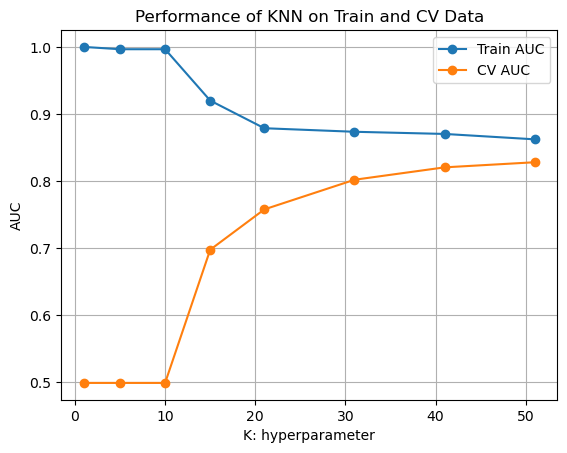

In [348]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.33,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,random_state=0)

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
X_cv_tfidf = tfidf_vect.transform(X_cv)

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_tfidf, y_train)
    
    y_train_pred = neigh.predict_proba(X_train_tfidf)[:, 1]
    y_cv_pred = neigh.predict_proba(X_cv_tfidf)[:, 1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC', marker='o')
plt.plot(K, cv_auc, label='CV AUC', marker='o')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance of KNN on Train and CV Data")
plt.show()


The optimal number of neighbors is 51.
Test AUC for K=51: 0.7974280654391066
Train AUC for K=51: 0.8621668682335455


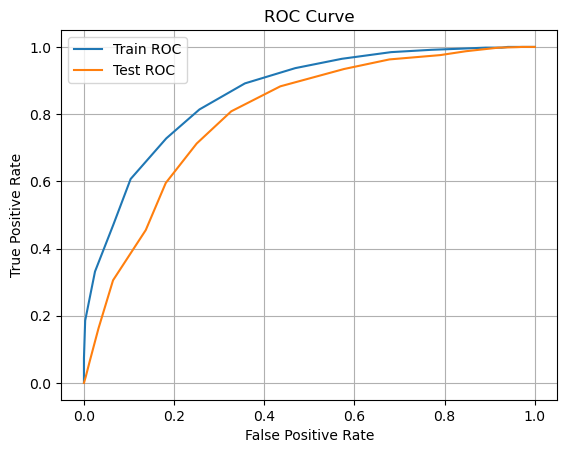

In [350]:
optimal_k = K[cv_auc.index(max(cv_auc))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

best_knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
best_knn.fit(X_train_tfidf, y_train)

y_test_pred_prob = best_knn.predict_proba(X_test_tfidf)[:, 1]
y_train_pred_prob = best_knn.predict_proba(X_train_tfidf)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_prob)
train_auc_optimal = roc_auc_score(y_train, y_train_pred_prob)

print(f'Test AUC for K={optimal_k}: {test_auc}')
print(f'Train AUC for K={optimal_k}: {train_auc_optimal}')

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()

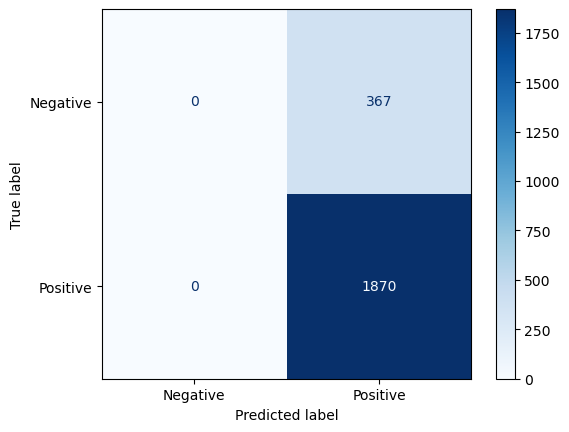

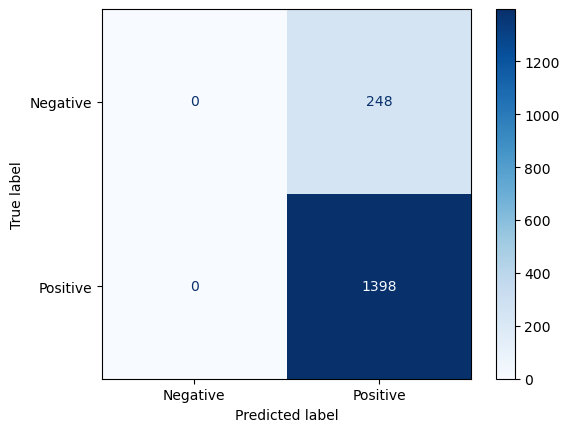

In [352]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_knn, X_train_tfidf, y_train, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

ConfusionMatrixDisplay.from_estimator(best_knn, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

<h3> Applying KNN brute force on AVG W2V </h3>

100%|██████████| 1646/1646 [00:01<00:00, 1214.61it/s]


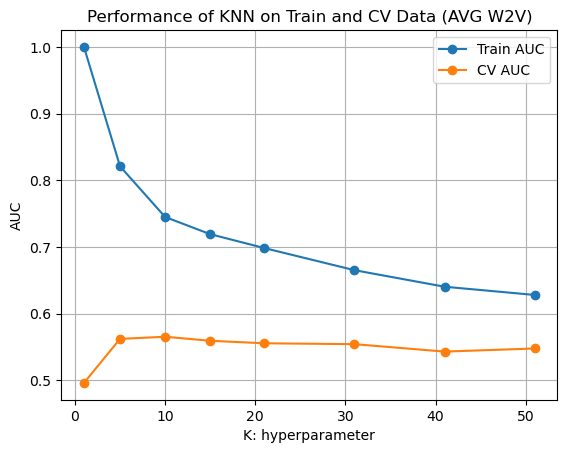

In [354]:
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.33,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,random_state=0)

# Tokenize sentences
list_of_sentences_train = [sentence.split() for sentence in X_train]
list_of_sentences_test = [sentence.split() for sentence in X_test]
list_of_sentences_cv = [sentence.split() for sentence in X_cv]

# Train Word2Vec model only on the training data
w2v_model = Word2Vec(sentences=list_of_sentences_train, vector_size=50, min_count=1, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

# Function to convert sentences to Average Word2Vec vectors
def get_avg_w2v_vectors(sentences, w2v_model, w2v_words):
    sent_vectors = []
    for sent in tqdm(sentences):
        sent_vec = np.zeros(50)
        cnt_words = 0
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

# Convert sentences to Average Word2Vec vectors
X_train_w2v = get_avg_w2v_vectors(list_of_sentences_train, w2v_model, w2v_words)
X_cv_w2v = get_avg_w2v_vectors(list_of_sentences_cv, w2v_model, w2v_words)
X_test_w2v = get_avg_w2v_vectors(list_of_sentences_test, w2v_model, w2v_words)

# Initialize lists to store AUC scores
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]

# Perform hyperparameter tuning
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_w2v, y_train)

    y_train_pred = neigh.predict_proba(X_train_w2v)[:, 1]
    y_cv_pred = neigh.predict_proba(X_cv_w2v)[:, 1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

# Plot the performance of the model on train and cross-validation data
plt.plot(K, train_auc, label='Train AUC', marker='o')
plt.plot(K, cv_auc, label='CV AUC', marker='o')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance of KNN on Train and CV Data (AVG W2V)")
plt.show()


The optimal number of neighbors is 10.
Test AUC for K=10: 0.5711817573492085
Train AUC for K=10: 0.744957670955427


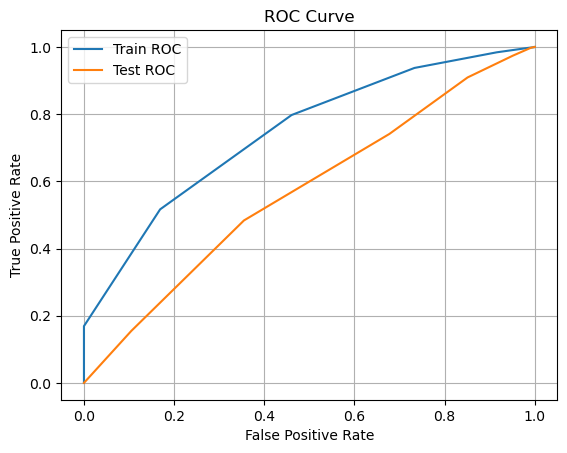

In [356]:
# Best hyperparameter
optimal_k = K[cv_auc.index(max(cv_auc))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

# Train the model with the best hyperparameter
best_knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
best_knn.fit(X_train_w2v, y_train)

# Predict and evaluate on test data
y_test_pred_prob = best_knn.predict_proba(X_test_w2v)[:, 1]
y_train_pred_prob = best_knn.predict_proba(X_train_w2v)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_prob)
train_auc_optimal = roc_auc_score(y_train, y_train_pred_prob)

print(f'Test AUC for K={optimal_k}: {test_auc}')
print(f'Train AUC for K={optimal_k}: {train_auc_optimal}')

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve')
plt.legend()
plt.show()

Train confusion matrix


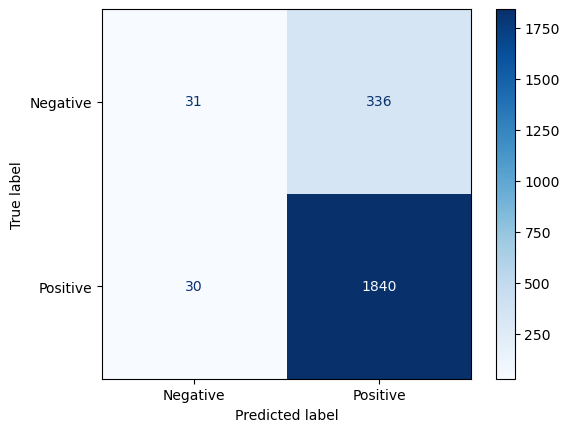

Test confusion matrix


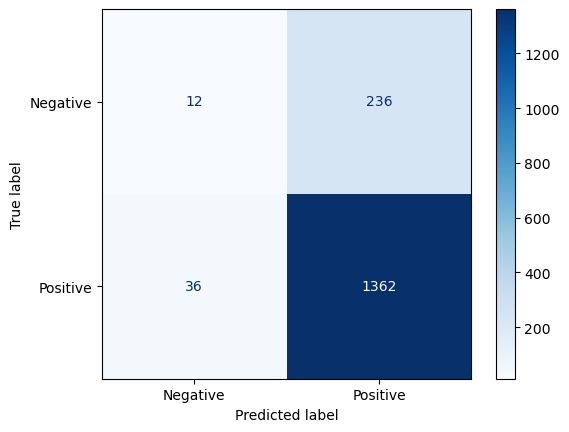

Train confusion matrix
[[  31  336]
 [  30 1840]]
Test confusion matrix
[[  12  236]
 [  36 1362]]


In [358]:
# Display Confusion Matrix using ConfusionMatrixDisplay.from_estimator
print("Train confusion matrix")
ConfusionMatrixDisplay.from_estimator(best_knn, X_train_w2v, y_train, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

print("Test confusion matrix")
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_w2v, y_test, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

y_train_pred = best_knn.predict(X_train_w2v)
y_test_pred = best_knn.predict(X_test_w2v)

# Print confusion matrices
print("Train confusion matrix")
print(confusion_matrix(y_train, y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(y_test, y_test_pred))


<h3>Applying KNN brute force on TFIDF W2V</h3>

100%|██████████| 1496/1496 [00:09<00:00, 158.85it/s]


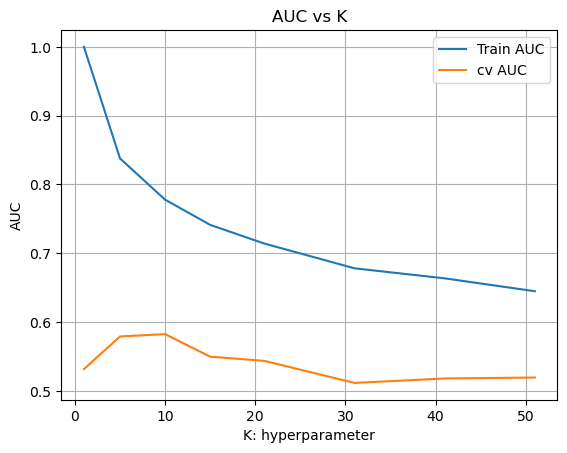

In [452]:
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.3,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3,random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_cv_tfidf = tfidf.transform(X_cv)

# Train Word2Vec model on the training data
list_of_sentences_train = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(list_of_sentences_train, vector_size=50, window=5, min_count=3, workers=4)

# Create a dictionary with word as key and idf as value
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names_out()
w2v_words = list(w2v_model.wv.index_to_key)

def compute_tfidf_w2v(tfidf, w2v_model, sentences):
    tfidf_sent_vectors = []
    for sent in tqdm(sentences):
        sent_vec = np.zeros(w2v_model.vector_size)
        weight_sum = 0
        for word in sent.split():
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word] * (sent.split().count(word) / len(sent.split()))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    return np.array(tfidf_sent_vectors)

# Compute TF-IDF weighted Word2Vec vectors for train, validation, and test sets
X_train_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_train)
X_cv_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_cv)
X_test_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_test)


# Define and train the KNN model
K = [1, 5, 10, 15, 21, 31, 41, 51]
train_auc = []
cv_auc = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    knn.fit(X_train_tfidf_w2v, y_train)
    
    y_train_pred_proba = knn.predict_proba(X_train_tfidf_w2v)[:, 1]
    y_cv_pred_proba = knn.predict_proba(X_cv_tfidf_w2v)[:, 1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred_proba))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_proba))

# Plotting AUC for different K values
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs K")
plt.show()

5
Test AUC: 0.5487193515052046
Train AUC: 0.8430283766482567


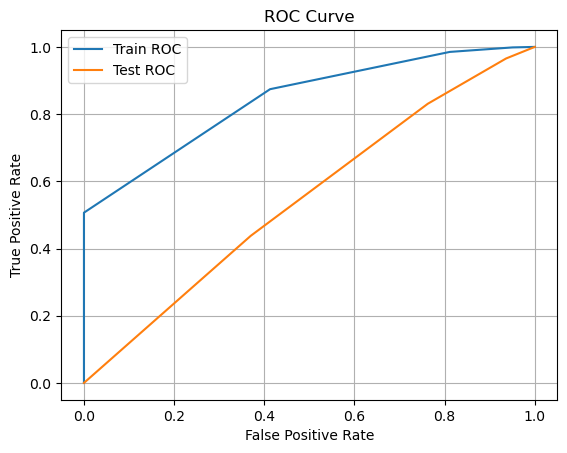

In [382]:
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
best_knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
best_knn.fit(X_train_tfidf_w2v, y_train)

# Evaluate on train & test set
y_train_pred_prob = best_knn.predict_proba(X_train_tfidf_w2v)[:, 1]
y_test_pred_prob = best_knn.predict_proba(X_test_tfidf_w2v)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_prob)
train_auc_optimal = roc_auc_score(y_train, y_train_pred_prob)

print(f"Test AUC: {test_auc}")
print(f"Train AUC: {train_auc_optimal}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve')
plt.legend()
plt.show()

Train confusion matrix
[[  80  344]
 [  30 1989]]
Validation confusion matrix
[[ 16 149]
 [ 42 840]]
Test confusion matrix
[[  14  205]
 [  44 1233]]


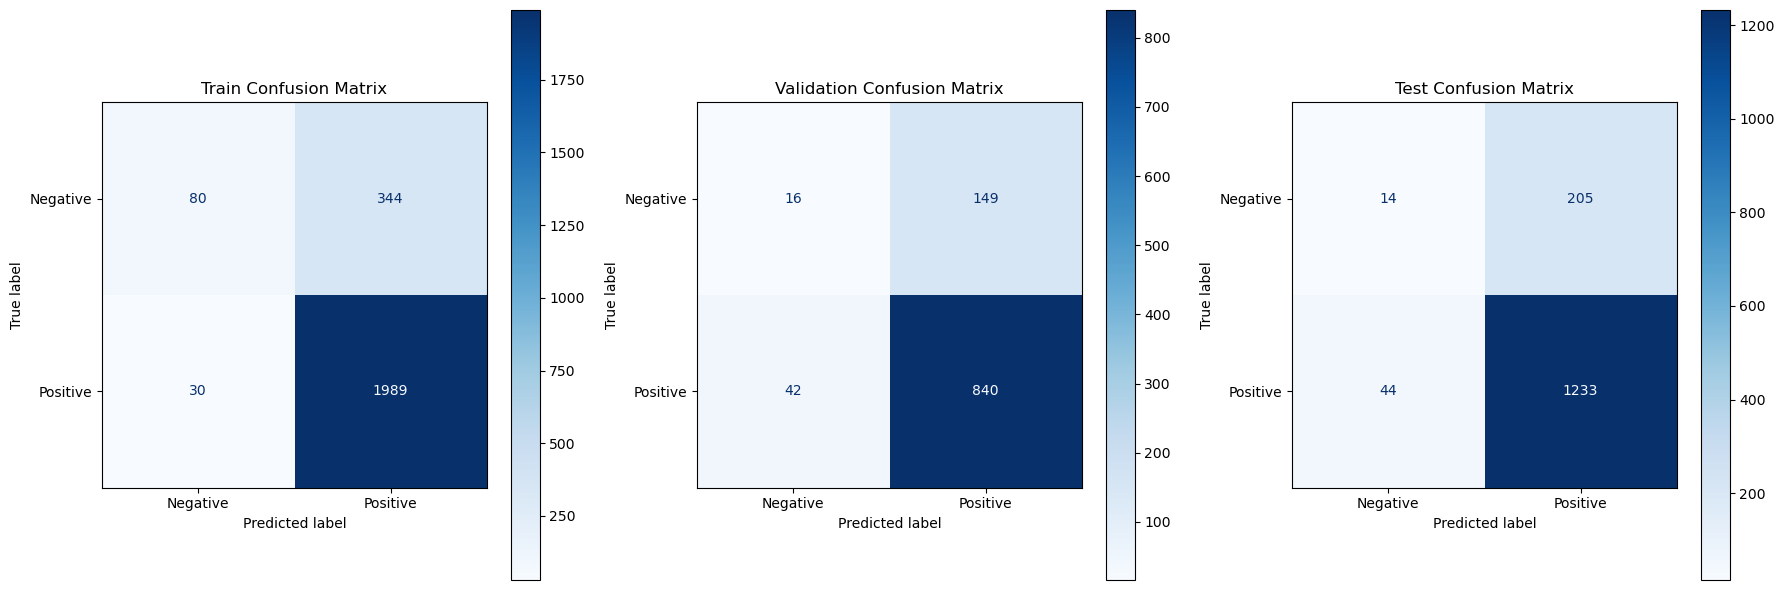

In [406]:
# Print confusion matrix for train, validation, and test sets
print("Train confusion matrix")
print(confusion_matrix(y_train, best_knn.predict(X_train_tfidf_w2v)))

print("Validation confusion matrix")
print(confusion_matrix(y_cv, best_knn.predict(X_cv_tfidf_w2v)))

print("Test confusion matrix")
print(confusion_matrix(y_test, best_knn.predict(X_test_tfidf_w2v)))

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ConfusionMatrixDisplay.from_estimator(best_knn, X_train_tfidf_w2v, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(best_knn, X_cv_tfidf_w2v, y_cv, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_tfidf_w2v, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
plt.tight_layout()
plt.show()

<h2>Applying KNN kd-tree</h2>

<h3>Applying KNN kd-tree on BOW</h3>

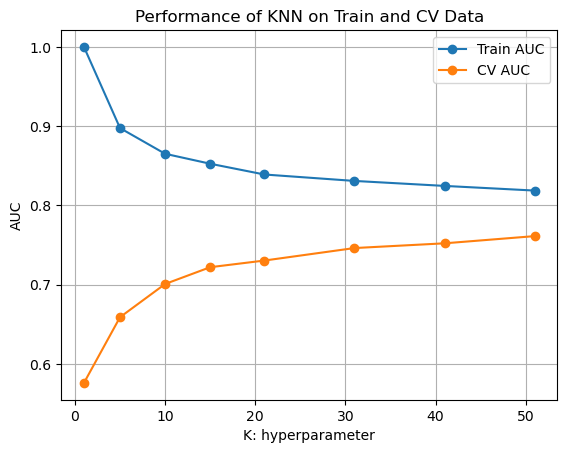

In [414]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

count_vec = CountVectorizer(min_df=10, max_features=500)
X_train_bow = count_vec.fit_transform(X_train).toarray()
X_test_bow = count_vec.transform(X_test).toarray()
X_cv_bow = count_vec.transform(X_cv).toarray()

# Apply KNN and evaluate using ROC-AUC
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(X_train_bow, y_train)
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs
    y_train_pred = neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred = neigh.predict_proba(X_cv_bow)[:,1]

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

# Plot the performance of the model on train and cross-validation data
plt.plot(K, train_auc, label='Train AUC', marker='o')
plt.plot(K, cv_auc, label='CV AUC', marker='o')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance of KNN on Train and CV Data")
plt.show()


The optimal number of neighbors is 51.
Test AUC for K=51: 0.7620815052402355
Train AUC for K=51: 0.8187571935691006


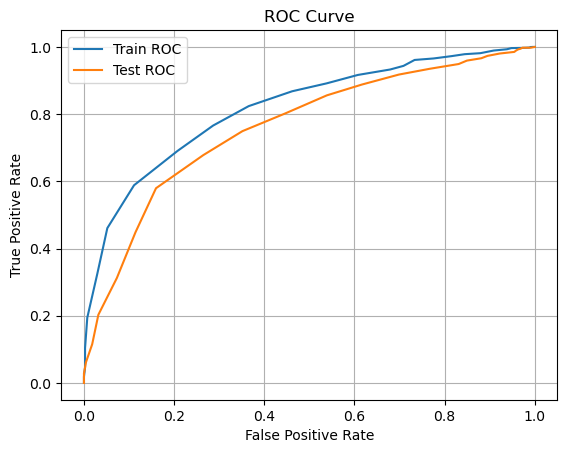

In [416]:
#best hyperparameter
optimal_k = K[cv_auc.index(max(cv_auc))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

# Train the model with the best hyperparameter
best_knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
best_knn.fit(X_train_bow, y_train)

# Predict and evaluate on test data
y_test_pred_prob = best_knn.predict_proba(X_test_bow)[:,1]
y_train_pred_prob = best_knn.predict_proba(X_train_bow)[:,1]

Test_auc = roc_auc_score(y_test, y_test_pred_prob)
Train_auc = roc_auc_score(y_train, y_train_pred_prob)

print(f'Test AUC for K={optimal_k}: {Test_auc}')
print(f'Train AUC for K={optimal_k}: {Train_auc}')

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()

Train confusion matrix
[[  12  393]
 [   6 2032]]
Test confusion matrix
[[   2  217]
 [   3 1274]]


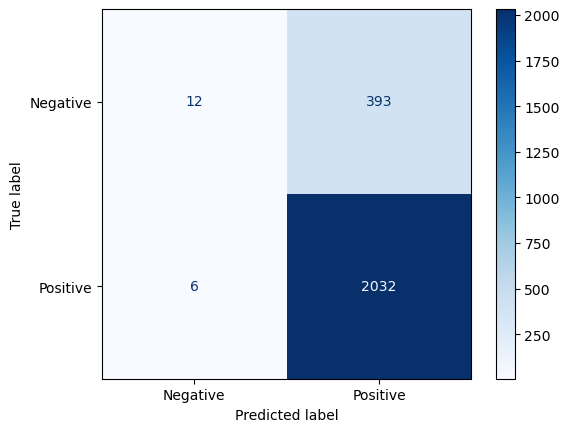

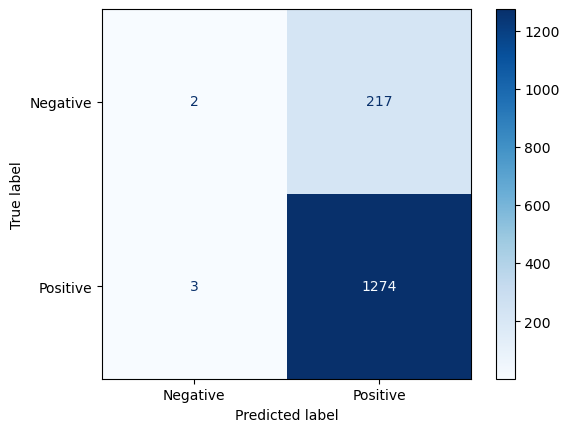

In [420]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, best_knn.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, best_knn.predict(X_test_bow)))
print('='*30)

ConfusionMatrixDisplay.from_estimator(best_knn, X_train_bow, y_train, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

ConfusionMatrixDisplay.from_estimator(best_knn, X_test_bow, y_test, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

<h3>Applying KNN kd-tree on TFIDF W2V</h3>

100%|██████████| 1496/1496 [00:02<00:00, 688.39it/s]


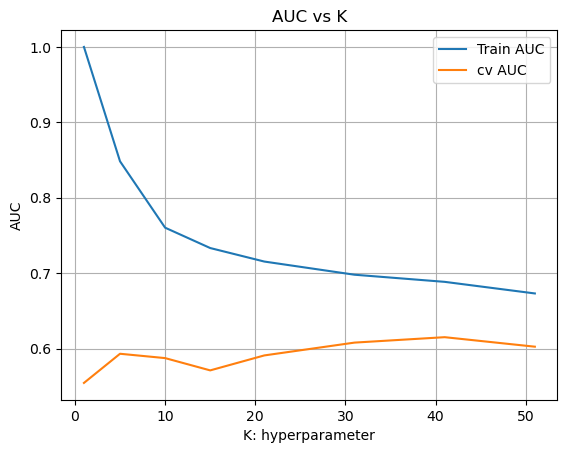

In [443]:
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.3,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3,random_state=0)

tfidf = TfidfVectorizer(min_df=10, max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_cv_tfidf = tfidf.transform(X_cv)

# Train Word2Vec model on the training data
list_of_sentences_train = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(list_of_sentences_train, vector_size=50, window=5, min_count=3, workers=4)

# Create a dictionary with word as key and idf as value
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names_out()
w2v_words = list(w2v_model.wv.index_to_key)

def compute_tfidf_w2v(tfidf, w2v_model, sentences):
    tfidf_sent_vectors = []
    for sent in tqdm(sentences):
        sent_vec = np.zeros(w2v_model.vector_size)
        weight_sum = 0
        for word in sent.split():
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word] * (sent.split().count(word) / len(sent.split()))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    return np.array(tfidf_sent_vectors)

# Compute TF-IDF weighted Word2Vec vectors for train, validation, and test sets
X_train_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_train)
X_cv_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_cv)
X_test_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_test)


# Define and train the KNN model
K = [1, 5, 10, 15, 21, 31, 41, 51]
train_auc = []
cv_auc = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_tfidf_w2v, y_train)
    
    y_train_pred_proba = knn.predict_proba(X_train_tfidf_w2v)[:, 1]
    y_cv_pred_proba = knn.predict_proba(X_cv_tfidf_w2v)[:, 1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred_proba))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_proba))

# Plotting AUC for different K values
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='cv AUC')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs K")
plt.show()

41
Test AUC: 0.5899493318744345
Train AUC: 0.6885078568918935


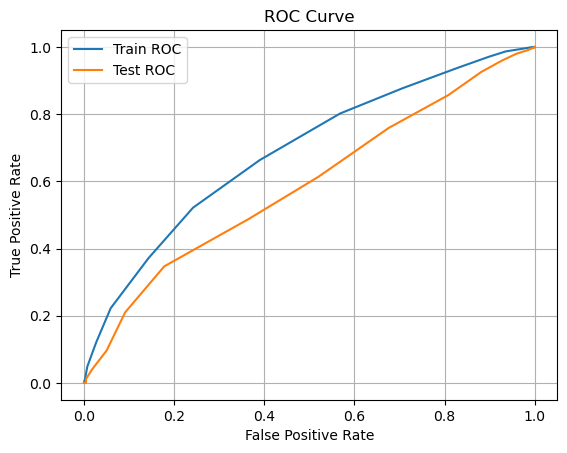

In [445]:
best_k = K[cv_auc.index(max(cv_auc))]
print(best_k)
best_knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
best_knn.fit(X_train_tfidf_w2v, y_train)

# Evaluate on train & test set
y_train_pred_prob = best_knn.predict_proba(X_train_tfidf_w2v)[:, 1]
y_test_pred_prob = best_knn.predict_proba(X_test_tfidf_w2v)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_prob)
train_auc_optimal = roc_auc_score(y_train, y_train_pred_prob)

print(f"Test AUC: {test_auc}")
print(f"Train AUC: {train_auc_optimal}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curve')
plt.legend()
plt.show()

Train confusion matrix
[[   0  405]
 [   0 2038]]
Validation confusion matrix
[[  0 184]
 [  0 863]]
Test confusion matrix
[[   0  219]
 [   0 1277]]


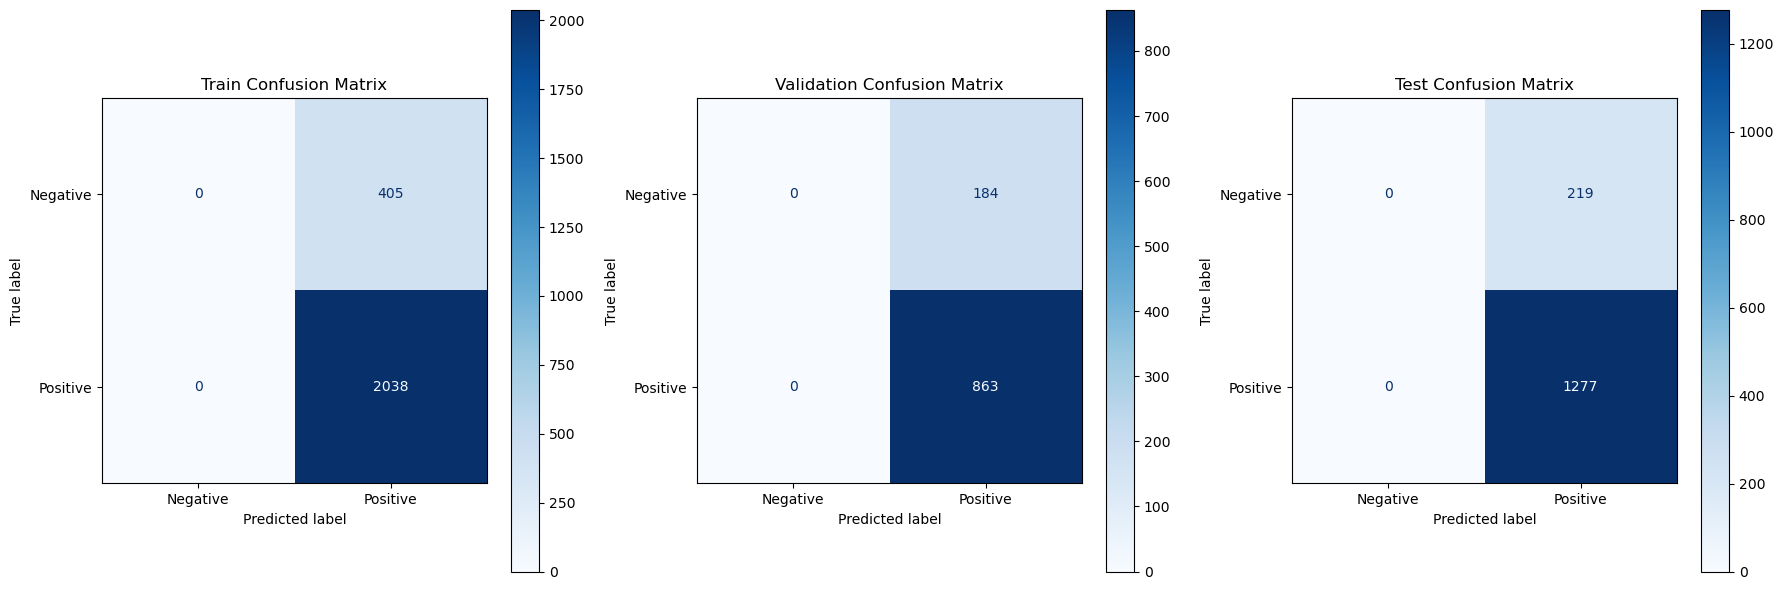

In [447]:
# Print confusion matrix for train, validation, and test sets
print("Train confusion matrix")
print(confusion_matrix(y_train, best_knn.predict(X_train_tfidf_w2v)))

print("Validation confusion matrix")
print(confusion_matrix(y_cv, best_knn.predict(X_cv_tfidf_w2v)))

print("Test confusion matrix")
print(confusion_matrix(y_test, best_knn.predict(X_test_tfidf_w2v)))

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ConfusionMatrixDisplay.from_estimator(best_knn, X_train_tfidf_w2v, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(best_knn, X_cv_tfidf_w2v, y_cv, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_tfidf_w2v, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
plt.tight_layout()
plt.show()

<h3>Applying KNN kd-tree on TFIDF</h3>

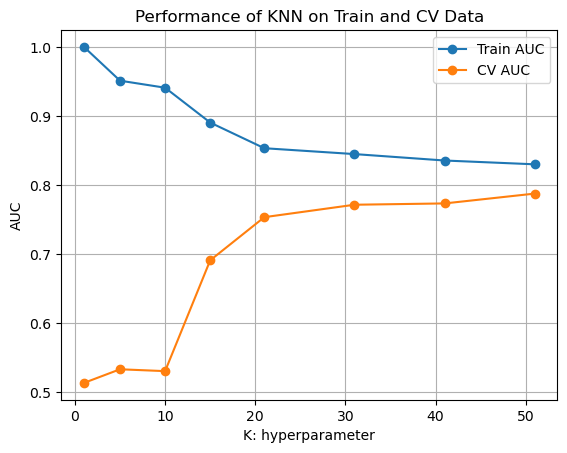

In [454]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.33,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,random_state=0)

tfidf_vect = TfidfVectorizer(min_df=10, max_features=500)
X_train_tfidf = tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vect.transform(X_test).toarray()
X_cv_tfidf = tfidf_vect.transform(X_cv).toarray()

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]

for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(X_train_tfidf, y_train)
    
    y_train_pred = neigh.predict_proba(X_train_tfidf)[:, 1]
    y_cv_pred = neigh.predict_proba(X_cv_tfidf)[:, 1]
    
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC', marker='o')
plt.plot(K, cv_auc, label='CV AUC', marker='o')
plt.grid()
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance of KNN on Train and CV Data")
plt.show()


The optimal number of neighbors is 51.
Test AUC for K=51: 0.7547461234943929
Train AUC for K=51: 0.8298539975811975


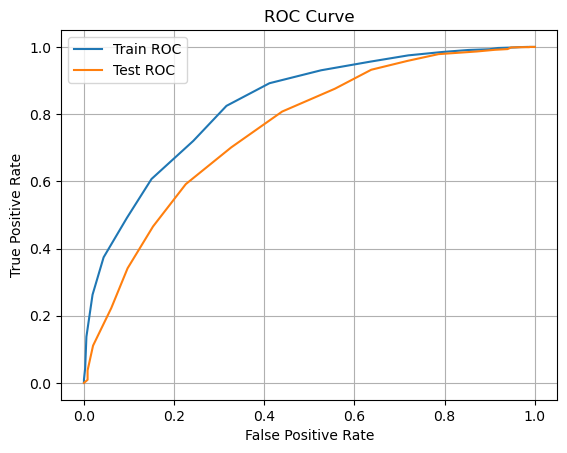

In [456]:
optimal_k = K[cv_auc.index(max(cv_auc))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

best_knn = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
best_knn.fit(X_train_tfidf, y_train)

y_test_pred_prob = best_knn.predict_proba(X_test_tfidf)[:, 1]
y_train_pred_prob = best_knn.predict_proba(X_train_tfidf)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_prob)
train_auc_optimal = roc_auc_score(y_train, y_train_pred_prob)

print(f'Test AUC for K={optimal_k}: {test_auc}')
print(f'Train AUC for K={optimal_k}: {train_auc_optimal}')

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()

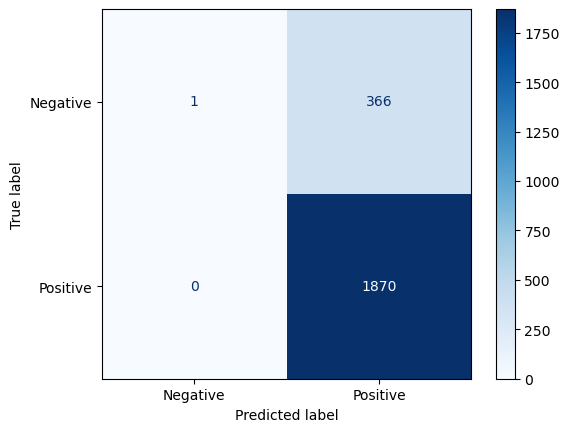

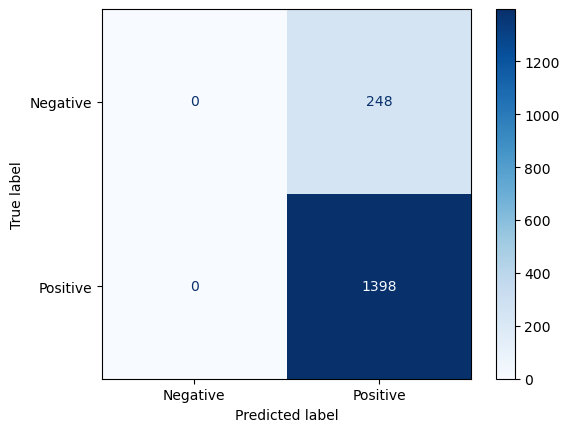

In [458]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_knn, X_train_tfidf, y_train, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

ConfusionMatrixDisplay.from_estimator(best_knn, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'], cmap='Blues')
plt.show()

<h2>Applying Multinomial Naive Bayes</h2>

<h3>Applying Naive Bayes on BOW</h3>

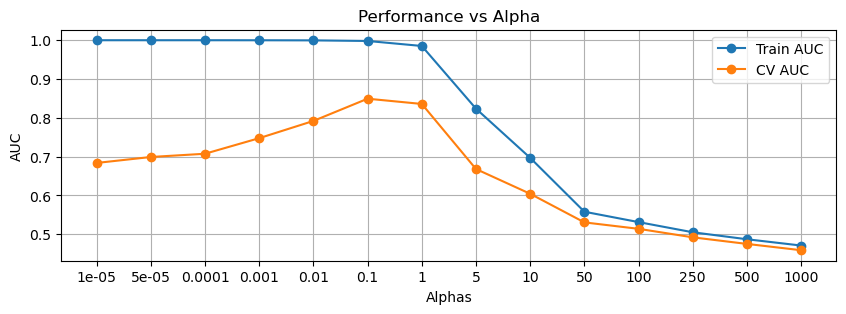

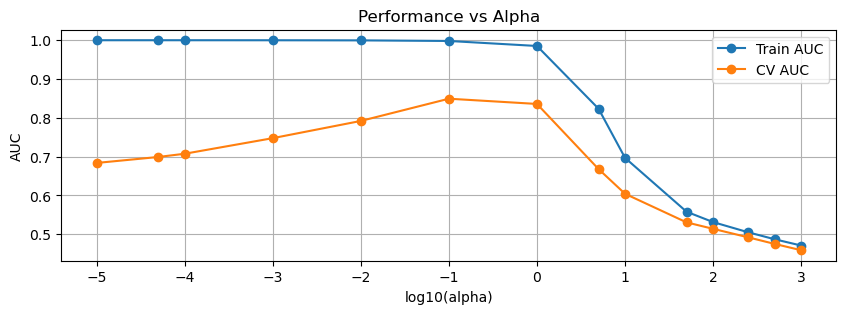

In [702]:
# Split the data first to avoid data leakage
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.3, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Vectorize the data
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

alphas = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 250, 500, 1000]
train_auc = []
cv_auc = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_bow, y_train)
    
    y_train_pred = model.predict_proba(X_train_bow)[:, 1]
    y_cv_pred = model.predict_proba(X_cv_bow)[:, 1]

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

# Plotting performance for each alpha
plt.figure(figsize=(10, 3))
plt.plot(range(len(alphas)), train_auc, label='Train AUC', marker='o')
plt.plot(range(len(alphas)), cv_auc, label='CV AUC', marker='o')
plt.xticks(range(len(alphas)), alphas)
plt.xlabel('Alphas')
plt.ylabel('AUC')
plt.grid()
plt.grid()
plt.legend()
plt.title('Performance vs Alpha')
plt.grid()
plt.show()

# Plotting performance for each alpha
plt.figure(figsize=(10, 3))
plt.plot(np.log10(alphas), train_auc, label='Train AUC', marker='o')
plt.plot(np.log10(alphas), cv_auc, label='CV AUC', marker='o')
plt.xlabel('log10(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.title('Performance vs Alpha')
plt.grid()
plt.show()

Best Alpha: 0.1


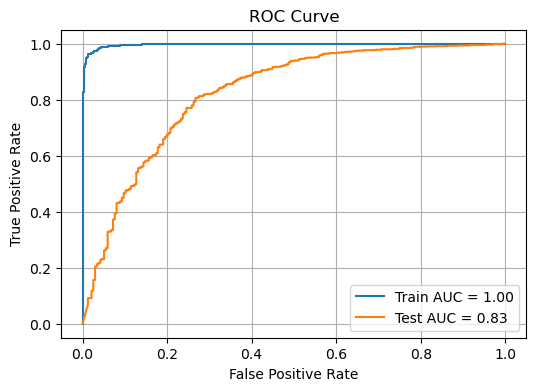

In [704]:
# Selecting the best alpha
best_alpha = alphas[np.argmax(cv_auc)]
print(f'Best Alpha: {best_alpha}')

# Train the model with the best alpha
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_bow, y_train)

# Evaluate on train & test data
y_train_pred_proba = best_model.predict_proba(X_train_bow)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_bow)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

Train confusion matrix
[[ 376   29]
 [  17 2021]]
Test confusion matrix
[[ 111  125]
 [  63 1197]]


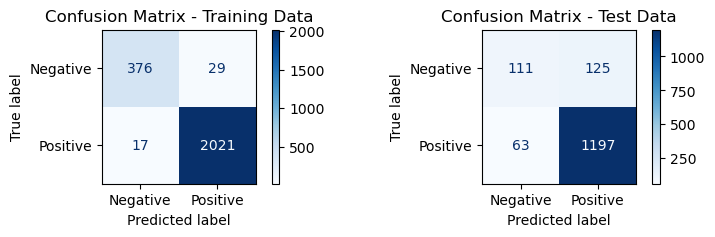

In [706]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, best_model.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, best_model.predict(X_test_bow)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_bow, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_bow, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [708]:
# Feature importance
feature_log_prob = best_model.feature_log_prob_
feature_names = count_vect.get_feature_names_out()

top10_pos_features = np.argsort(feature_log_prob[1, :])[-10:]
top10_neg_features = np.argsort(feature_log_prob[0, :])[-10:]

print("\nTop 10 positive features:")
for i in top10_pos_features:
    print(f'{feature_names[i]}: {feature_log_prob[1, i]:.4f}')

print("\nTop 10 negative features:")
for i in top10_neg_features:
    print(f'{feature_names[i]}: {feature_log_prob[0, i]:.4f}')


Top 10 positive features:
coffee: -5.1053
one: -5.0735
flavor: -5.0513
product: -5.0002
love: -4.9554
taste: -4.8975
great: -4.6423
good: -4.6038
like: -4.5627
not: -3.7502

Top 10 negative features:
good: -5.3364
no: -5.3037
flavor: -5.2616
food: -5.1451
taste: -4.9538
one: -4.8462
would: -4.8260
product: -4.6951
like: -4.5536
not: -3.3915


In [710]:
table = PrettyTable()
table.field_names = ["Model", "Best Alpha", "Train AUC", "Test AUC"]
table.add_row(["MultinomialNB (BoW)", best_alpha, f"{train_auc:.2f}", f"{test_auc:.2f}"])

<h3>Applying Naive Bayes on TFIDF</h3>

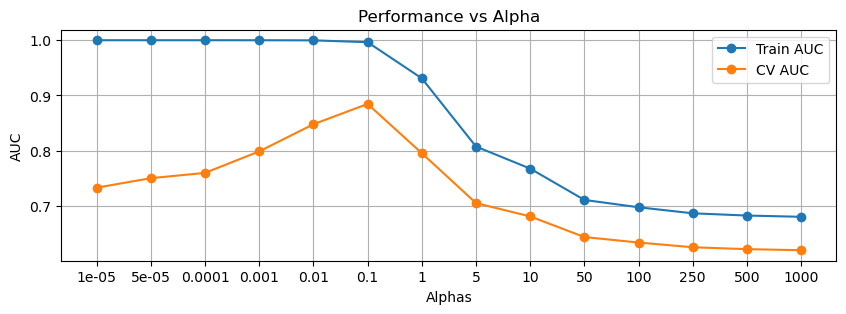

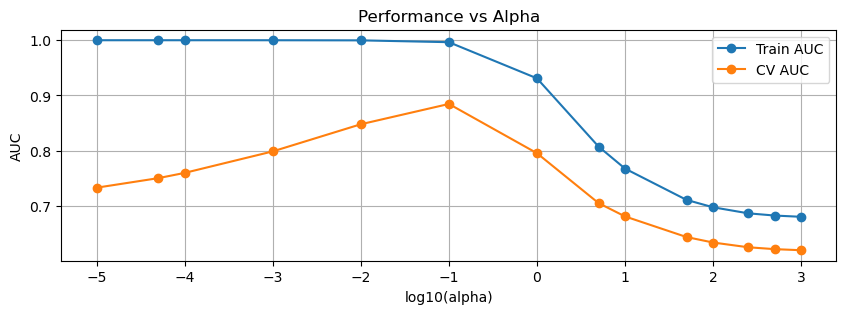

In [713]:
# Split the data first to avoid data leakage
# Split data into train, cross-validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, labels, test_size=0.3, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Vectorize the data
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_cv_tfidf = tfidf.transform(X_cv)
X_test_tfidf = tfidf.transform(X_test)

alphas = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 250, 500, 1000]
train_auc = []
cv_auc = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_tfidf, y_train)
    
    y_train_pred = model.predict_proba(X_train_tfidf)[:, 1]
    y_cv_pred = model.predict_proba(X_cv_tfidf)[:, 1]

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

# Plotting performance for each alpha
plt.figure(figsize=(10, 3))
plt.plot(range(len(alphas)), train_auc, label='Train AUC', marker='o')
plt.plot(range(len(alphas)), cv_auc, label='CV AUC', marker='o')
plt.xticks(range(len(alphas)), alphas)
plt.xlabel('Alphas')
plt.ylabel('AUC')
plt.grid()
plt.grid()
plt.legend()
plt.title('Performance vs Alpha')
plt.grid()
plt.show()

# Plotting performance for each alpha
plt.figure(figsize=(10, 3))
plt.plot(np.log10(alphas), train_auc, label='Train AUC', marker='o')
plt.plot(np.log10(alphas), cv_auc, label='CV AUC', marker='o')
plt.xlabel('log10(alpha)')
plt.ylabel('AUC')
plt.legend()
plt.title('Performance vs Alpha')
plt.grid()
plt.show()

Best Alpha: 0.1


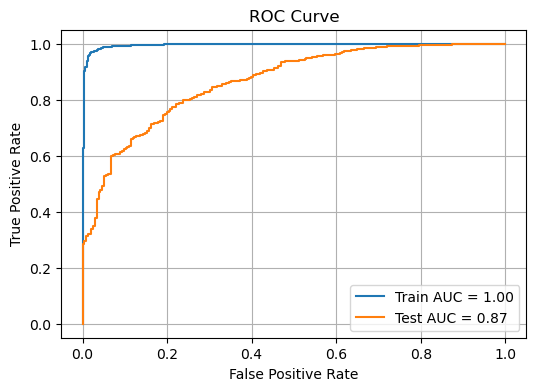

In [715]:
# Selecting the best alpha
best_alpha = alphas[np.argmax(cv_auc)]
print(f'Best Alpha: {best_alpha}')

# Train the model with the best alpha
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)

# Evaluate on train & test data
y_train_pred_proba = best_model.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_tfidf)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

Train confusion matrix
[[ 290  115]
 [   2 2036]]
Test confusion matrix
[[  38  198]
 [   4 1256]]


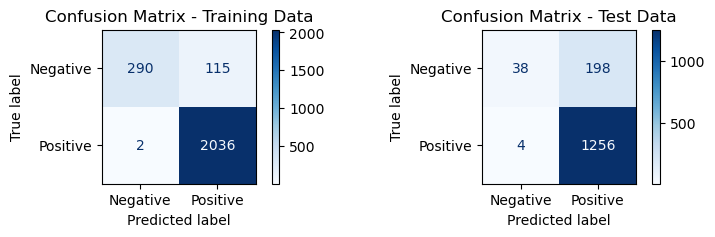

In [717]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, best_model.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, best_model.predict(X_test_tfidf)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_tfidf, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [719]:
# Feature importance
feature_log_prob = best_model.feature_log_prob_
feature_names = tfidf.get_feature_names_out()

top10_pos_features = np.argsort(feature_log_prob[1, :])[-10:]
top10_neg_features = np.argsort(feature_log_prob[0, :])[-10:]

print("\nTop 10 positive features:")
for i in top10_pos_features:
    print(f'{feature_names[i]}: {feature_log_prob[1, i]:.4f}')

print("\nTop 10 negative features:")
for i in top10_neg_features:
    print(f'{feature_names[i]}: {feature_log_prob[0, i]:.4f}')


Top 10 positive features:
flavor: -5.5732
taste: -5.4820
coffee: -5.4713
product: -5.4641
chips: -5.4588
like: -5.3424
love: -5.3131
good: -5.2195
great: -5.1478
not: -4.8794

Top 10 negative features:
tea: -5.9990
food: -5.9873
chips: -5.9510
flavor: -5.9346
one: -5.7714
taste: -5.7101
would: -5.6449
product: -5.5756
like: -5.5118
not: -4.6790


In [721]:
table.add_row(["MultinomialNB (TF-IDF)", best_alpha, f"{train_auc:.2f}", f"{test_auc:.2f}"])
print(table)

+------------------------+------------+-----------+----------+
|         Model          | Best Alpha | Train AUC | Test AUC |
+------------------------+------------+-----------+----------+
|  MultinomialNB (BoW)   |    0.1     |    1.00   |   0.83   |
| MultinomialNB (TF-IDF) |    0.1     |    1.00   |   0.87   |
+------------------------+------------+-----------+----------+


<h2>Applying Logistic Regression</h2>

<h3>Logistic Regression on (BOW)</h3>

In [1060]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_reviews, labels, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the data using BOW
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
X_val_bow = count_vect.transform(X_val)
X_test_bow = count_vect.transform(X_test)

# Define the hyperparameter grid
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Perform GridSearchCV
grid_search = GridSearchCV(LogisticRegression(solver='liblinear',max_iter=150), param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train_bow, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters: ", best_params)
print("Best AUC: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1}
Best AUC:  0.8941698982147296


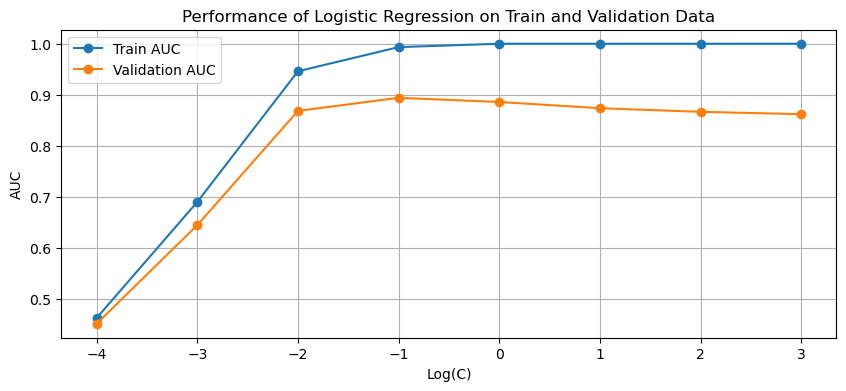

In [1062]:
# Plot the performance of the model on train and cross-validation data for each hyperparameter
train_auc = grid_search.cv_results_['mean_train_score']
val_auc = grid_search.cv_results_['mean_test_score']
param_range = [np.log10(c) for c in param_grid['C']]

plt.figure(figsize=(10, 4))
plt.plot(param_range, train_auc, label='Train AUC', marker='o')
plt.plot(param_range, val_auc, label='Validation AUC', marker='o')
plt.xlabel('Log(C)')
plt.ylabel('AUC')
plt.title('Performance of Logistic Regression on Train and Validation Data')
plt.legend()
plt.grid(True)
plt.show()

Test AUC: 0.8937
Train AUC: 0.9921


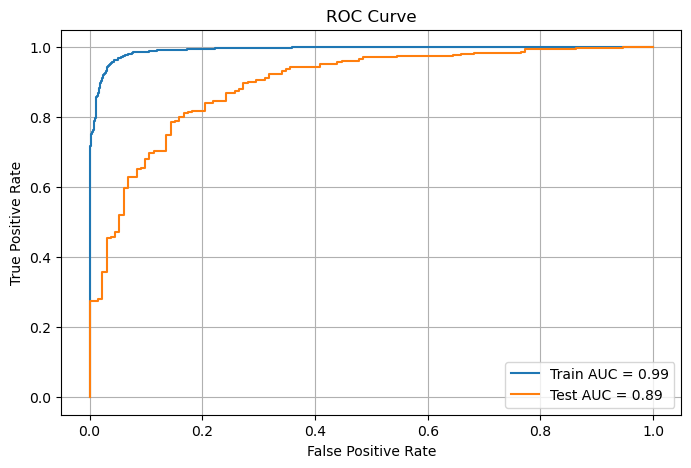

In [1064]:
# Train the model with the best hyperparameter on the entire training set
best_model.fit(X_train_bow, y_train)

# Predict probabilities for test data
y_train_pred_proba = best_model.predict_proba(X_train_bow)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_bow)[:, 1]

# Calculate AUC for test data
train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test AUC: {:.4f}".format(test_auc))
print("Train AUC: {:.4f}".format(train_auc))

# Plot ROC curve for test data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)


plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [1068]:
# Get the weights W after fitting the model with the data X (Train data)
W = best_model.coef_

# Add noise to the X (X' = X + e) and get the new data set X'
epsilon = 0.0001
X_train_bow_perturbed = X_train_bow.astype(np.float64).copy()
X_train_bow_perturbed.data += epsilon

# Fit the model again on data X' and get the weights W'
best_model.fit(X_train_bow_perturbed, y_train)
W_perturbed = best_model.coef_

# Add a small eps value to W and W' to avoid division by zero
eps = 1e-6
W += eps
W_perturbed += eps

# Calculate the percentage change between W and W'
percentage_change = np.abs((W - W_perturbed) / W) * 100

# Calculate percentiles
percentiles = np.percentile(percentage_change, np.arange(0, 101, 10))
for i in range(len(percentiles)):
    print(f'{i*10}th percentile:{percentiles[i]}')
print('\n')

detailed_percentiles = np.percentile(percentage_change, np.arange(99, 100, 0.1))
for i in range(len(detailed_percentiles)):
    print(f'{99 + i*0.1}th percentile: {detailed_percentiles[i]}')

0th percentile:9.951097548503978e-05
10th percentile:0.0013069579798753422
20th percentile:0.0022068103652613347
30th percentile:0.003410062338447573
40th percentile:0.005073068186157904
50th percentile:0.0074231302930202175
60th percentile:0.0105847613844676
70th percentile:0.01605143285884006
80th percentile:0.028797340564208542
90th percentile:0.08065577774068261
100th percentile:44.90438368569187


99.0th percentile: 7.872901002885942
99.1th percentile: 8.238690857976852
99.2th percentile: 9.370518454489067
99.3th percentile: 15.166671085996738
99.4th percentile: 17.454775230999918
99.5th percentile: 17.49984297287139
99.6th percentile: 32.720522901290245
99.7th percentile: 37.94004104203756
99.8th percentile: 37.94004104203756
99.9th percentile: 37.94004104203756


In [1070]:
# Print the feature names whose % change is more than a threshold 
threshold = 17.49984297287139
feature_names = count_vect.get_feature_names_out()
important_features = [feature_names[i] for i in range(len(percentage_change[0])) if percentage_change[0][i] > threshold]
print("Features with % change more than threshold:")
print(important_features)

Features with % change more than threshold:
['acidcayenne', 'advantages', 'ameliorated', 'cancer', 'carnation', 'colour', 'dismay', 'eggos', 'excercise', 'faults', 'favourite', 'favourites', 'flavoured', 'flavournaturally', 'ghiradelli', 'jalapino', 'kidneys', 'kindneys', 'knit', 'linked', 'microbrew', 'moderation', 'nations', 'nutritionists', 'oleoresin', 'othr', 'outgoing', 'paprika', 'peppercitric', 'pepperpaprika', 'porty', 'potatoesvegetable', 'powderchili', 'powderpaprikatorula', 'powdersugarsaltonion', 'powdertomato', 'productionas', 'ptato', 'sections', 'sensible', 'slept', 'stonger', 'teaches', 'thesedifferent', 'thinning', 'thiscan', 'toster', 'wisdom', 'withstand', 'yeastgarlic']


In [1072]:
# Train a model with L1 regularization
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=best_params['C'])
log_reg_l1.fit(X_train_bow, y_train)

# Get the weight vector
W_l1 = log_reg_l1.coef_

# Calculate sparsity
sparsity = np.mean(W_l1 == 0) * 100
print("Sparsity of the weight vector: {:.2f}%".format(sparsity))
print(np.count_nonzero(W_l1))

Sparsity of the weight vector: 99.13%
93


In [1074]:
# Get the top 10 important features for positive and negative classes
feature_names = count_vect.get_feature_names_out()
sorted_indices = np.argsort(best_model.coef_[0])
top_positive_features = [feature_names[i] for i in sorted_indices[-10:]]
top_negative_features = [feature_names[i] for i in sorted_indices[:10]]

print("Top 10 positive features:")
print(top_positive_features)
print("Top 10 negative features:")
print(top_negative_features)

Top 10 positive features:
['best', 'perfect', 'wonderful', 'excellent', 'loves', 'good', 'nice', 'delicious', 'love', 'great']
Top 10 negative features:
['disappointed', 'thought', 'away', 'nasty', 'disappointing', 'swiss', 'terrible', 'not', 'bad', 'worst']


Train confusion matrix
[[ 365  177]
 [   5 2793]]
Test confusion matrix
[[ 45  87]
 [ 14 677]]


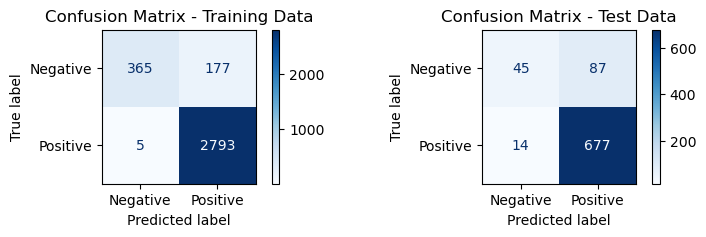

In [1076]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, best_model.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, best_model.predict(X_test_bow)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_bow, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_bow, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [1082]:
table = PrettyTable()
table.field_names = ["Model", "Best C", "Train AUC", "Test AUC"]
table.add_row(["Logistic Regression (BoW)", best_params['C'], f"{train_auc:.2f}", f"{test_auc:.2f}"])
print(table)

+---------------------------+--------+-----------+----------+
|           Model           | Best C | Train AUC | Test AUC |
+---------------------------+--------+-----------+----------+
| Logistic Regression (BoW) |  0.1   |    0.99   |   0.89   |
+---------------------------+--------+-----------+----------+


<h3>Logistic Regression on (TFIDF)</h3>

In [1084]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_reviews, labels, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the data using TF-IDF
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Define the hyperparameter grid
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Perform GridSearchCV
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_auc = grid_search.best_score_

print("best Model: ", best_model)
print("Best hyperparameters: ", best_params)
print("Best AUC: ", best_auc)

best Model:  LogisticRegression(C=10, solver='liblinear')
Best hyperparameters:  {'C': 10}
Best AUC:  0.9138036749153937


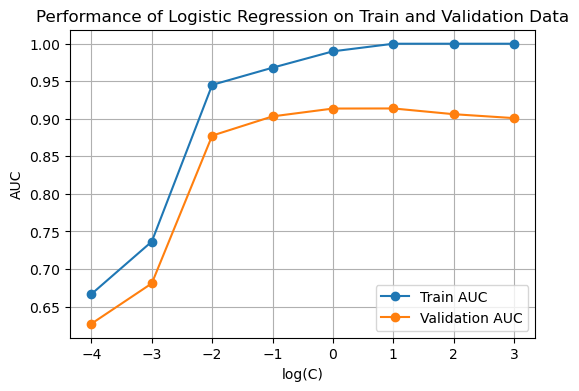

In [1085]:
# Plot performance of the model on train and cross-validation data for each hyperparameter
train_auc = grid_search.cv_results_['mean_train_score']
val_auc = grid_search.cv_results_['mean_test_score']
param_range = [np.log10(c) for c in param_grid['C']]

plt.figure(figsize=(6, 4))
plt.plot(param_range, train_auc, label='Train AUC', marker='o')
plt.plot(param_range, val_auc, label='Validation AUC', marker='o')
plt.xlabel('log(C)')
plt.ylabel('AUC')
plt.title('Performance of Logistic Regression on Train and Validation Data')
plt.legend()
plt.grid()
plt.show()

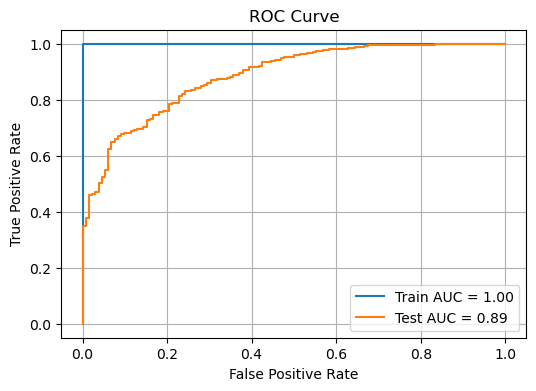

In [1086]:
# Train a model with L1 regularization
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=best_params['C'])
log_reg_l1.fit(X_train_tfidf, y_train)

# Evaluate on train & test data
y_train_pred_proba = log_reg_l1.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_proba = log_reg_l1.predict_proba(X_test_tfidf)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

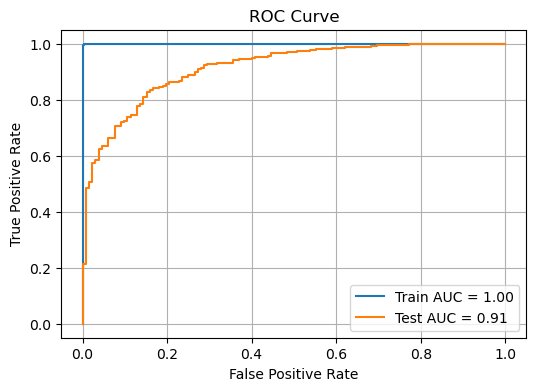

In [1087]:
# Train the model with the best hyperparameter
best_model = LogisticRegression(solver='liblinear', C=best_params['C'])
best_model.fit(X_train_tfidf, y_train)

# Evaluate on train & test data
y_train_pred_proba = best_model.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_tfidf)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

In [1089]:
# Get the top 10 important features for positive and negative classes
feature_names = tfidf.get_feature_names_out()
sorted_indices = np.argsort(best_model.coef_[0])
top_positive_features = [feature_names[i] for i in sorted_indices[-10:]]
top_negative_features = [feature_names[i] for i in sorted_indices[:10]]

print("Top 10 positive features:")
print(top_positive_features)
print('-'*100)
print("Top 10 negative features:")
print(top_negative_features)

Top 10 positive features:
['excellent', 'perfect', 'best', 'loves', 'wonderful', 'delicious', 'nice', 'good', 'love', 'great']
----------------------------------------------------------------------------------------------------
Top 10 negative features:
['not', 'thought', 'disappointed', 'disappointing', 'swiss', 'worst', 'terrible', 'away', 'return', 'ingredient']


Train confusion matrix
[[ 538    4]
 [   0 2798]]
Test confusion matrix
[[ 69  63]
 [ 33 658]]


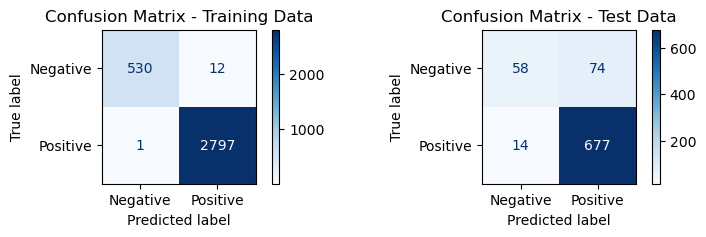

In [1092]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg_l1.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg_l1.predict(X_test_tfidf)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_tfidf, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_tfidf, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [1095]:
table.add_row(["Logistic Regression (TFIDF)", best_params['C'], f"{train_auc:.2f}", f"{test_auc:.2f}"])
print(table)

+-----------------------------+--------+-----------+----------+
|            Model            | Best C | Train AUC | Test AUC |
+-----------------------------+--------+-----------+----------+
|  Logistic Regression (BoW)  |  0.1   |    0.99   |   0.89   |
| Logistic Regression (TFIDF) |   10   |    1.00   |   0.91   |
+-----------------------------+--------+-----------+----------+


<h3>Applying Logistic Regression on (AVG W2V)</h3>

In [1123]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_reviews, labels, test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize sentences
list_of_sentences_train = [sentence.split() for sentence in X_train]
list_of_sentences_test = [sentence.split() for sentence in X_test]
list_of_sentences_val = [sentence.split() for sentence in X_val]

# Train Word2Vec model only on the training data
w2v_model = Word2Vec(sentences=list_of_sentences_train, vector_size=300, min_count=1, window=5, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

# Function to convert sentences to Average Word2Vec vectors
def get_avg_w2v_vectors(sentences, w2v_model, w2v_words):
    sent_vectors = []
    for sent in tqdm(sentences):
        sent_vec = np.zeros(300)
        cnt_words = 0
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

# Convert sentences to Average Word2Vec vectors
X_train_w2v = get_avg_w2v_vectors(list_of_sentences_train, w2v_model, w2v_words)
X_cv_w2v = get_avg_w2v_vectors(list_of_sentences_val, w2v_model, w2v_words)
X_test_w2v = get_avg_w2v_vectors(list_of_sentences_test, w2v_model, w2v_words)

# Define the hyperparameter grid
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train_w2v, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best hyperparameters: ", best_params)
print("Best AUC: ", best_auc)

100%|██████████| 823/823 [00:00<00:00, 1198.80it/s]


Best hyperparameters:  {'C': 10000}
Best AUC:  0.8634455560214308


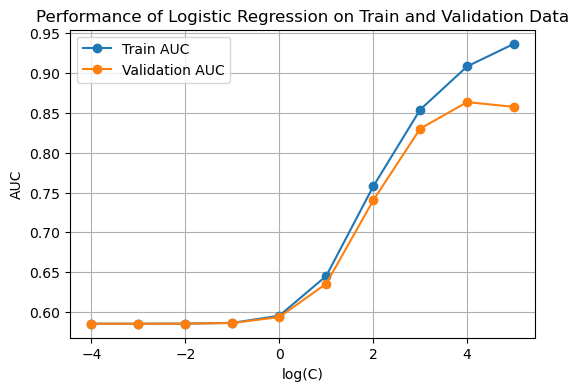

In [1125]:
# Plot performance of the model on train and cross-validation data for each hyperparameter
train_auc = grid_search.cv_results_['mean_train_score']
val_auc = grid_search.cv_results_['mean_test_score']
param_range = [np.log10(c) for c in param_grid['C']]

plt.figure(figsize=(6, 4))
plt.plot(param_range, train_auc, label='Train AUC', marker='o')
plt.plot(param_range, val_auc, label='Validation AUC', marker='o')
plt.xlabel('log(C)')
plt.ylabel('AUC')
plt.title('Performance of Logistic Regression on Train and Validation Data')
plt.legend()
plt.grid()
plt.show()

C:\Users\karti\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


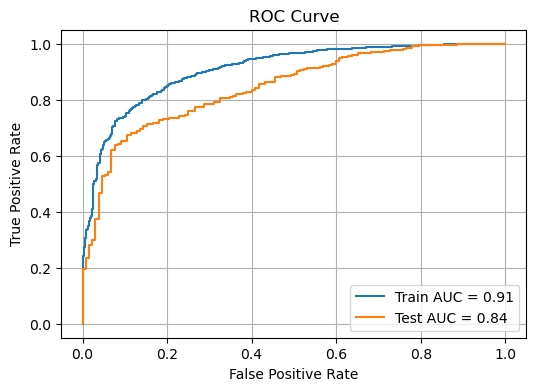

In [1127]:
# Train a model with L1 regularization
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=150, C=best_params['C'])
log_reg_l1.fit(X_train_w2v, y_train)

# Evaluate on train & test data
y_train_pred_proba = log_reg_l1.predict_proba(X_train_w2v)[:, 1]
y_test_pred_proba = log_reg_l1.predict_proba(X_test_w2v)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

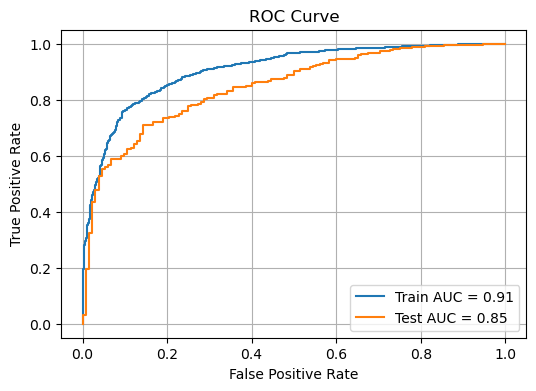

In [1128]:
# Train the model with the best hyperparameter using L2 regularization
best_model = LogisticRegression(solver='liblinear', max_iter=150, C=best_params['C'])
best_model.fit(X_train_w2v, y_train)

# Evaluate on train & test data
y_train_pred_proba = best_model.predict_proba(X_train_w2v)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_w2v)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

Train confusion matrix
[[ 252  290]
 [  81 2717]]
Test confusion matrix
[[ 46  86]
 [ 23 668]]


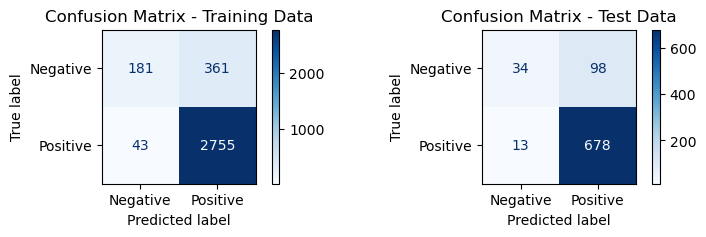

In [1129]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg_l1.predict(X_train_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg_l1.predict(X_test_w2v)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_w2v, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_w2v, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [1121]:
table.add_row(["Logistic Regression (AVG W2V)", best_params['C'], f"{train_auc:.2f}", f"{test_auc:.2f}"])
print(table)

+-------------------------------+--------+-----------+----------+
|             Model             | Best C | Train AUC | Test AUC |
+-------------------------------+--------+-----------+----------+
|   Logistic Regression (BoW)   |  0.1   |    0.99   |   0.89   |
|  Logistic Regression (TFIDF)  |   10   |    1.00   |   0.91   |
| Logistic Regression (AVG W2V) | 10000  |    0.90   |   0.85   |
+-------------------------------+--------+-----------+----------+


<h3>Logistic Regression on TFIDF W2V</h3>

In [1147]:
#split the data into test and train
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_reviews, labels, test_size=0.33, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_cv_tfidf = tfidf.transform(X_cv)

# Train Word2Vec model on the training data
list_of_sentences_train = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(list_of_sentences_train, vector_size=50, window=5, min_count=5, workers=4)

# Create a dictionary with word as key and idf as value
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names_out()
w2v_words = list(w2v_model.wv.index_to_key)

def compute_tfidf_w2v(tfidf, w2v_model, sentences):
    tfidf_sent_vectors = []
    for sent in tqdm(sentences):
        sent_vec = np.zeros(w2v_model.vector_size)
        weight_sum = 0
        for word in sent.split():
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word] * (sent.split().count(word) / len(sent.split()))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    return np.array(tfidf_sent_vectors)

# Compute TF-IDF weighted Word2Vec vectors for train, validation, and test sets
X_train_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_train)
X_cv_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_cv)
X_test_tfidf_w2v = compute_tfidf_w2v(tfidf, w2v_model, X_test)

# Define the hyperparameter grid
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train_tfidf_w2v, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best hyperparameters: ", best_params)
print("Best AUC: ", best_auc)

100%|██████████| 823/823 [00:05<00:00, 154.57it/s]


Best hyperparameters:  {'C': 1000}
Best AUC:  0.7585595900002771


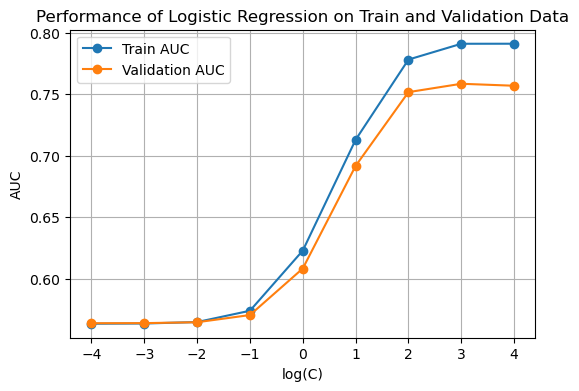

In [1148]:
# Plot performance of the model on train and cross-validation data for each hyperparameter
train_auc = grid_search.cv_results_['mean_train_score']
val_auc = grid_search.cv_results_['mean_test_score']
param_range = [np.log10(c) for c in param_grid['C']]

plt.figure(figsize=(6, 4))
plt.plot(param_range, train_auc, label='Train AUC', marker='o')
plt.plot(param_range, val_auc, label='Validation AUC', marker='o')
plt.xlabel('log(C)')
plt.ylabel('AUC')
plt.title('Performance of Logistic Regression on Train and Validation Data')
plt.legend()
plt.grid()
plt.show()

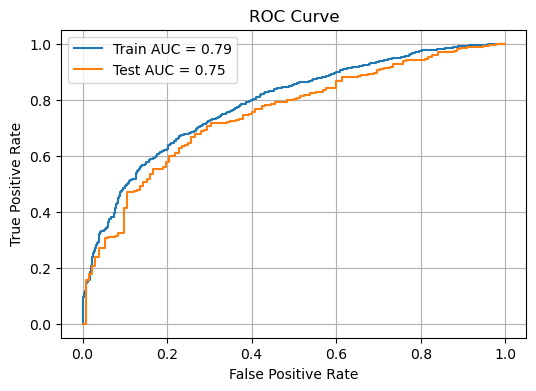

In [1149]:
# Train a model with L1 regularization
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', max_iter=150, C=best_params['C'])
log_reg_l1.fit(X_train_tfidf_w2v, y_train)

# Evaluate on train & test data
y_train_pred_proba = log_reg_l1.predict_proba(X_train_tfidf_w2v)[:, 1]
y_test_pred_proba = log_reg_l1.predict_proba(X_test_tfidf_w2v)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

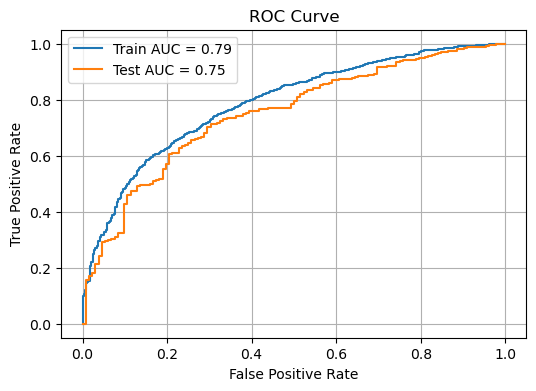

In [1150]:
# Train the model with the best hyperparameter using L2 regularization
best_model = LogisticRegression(solver='liblinear', max_iter=150, C=best_params['C'])
best_model.fit(X_train_tfidf_w2v, y_train)

# Evaluate on train & test data
y_train_pred_proba = best_model.predict_proba(X_train_tfidf_w2v)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_tfidf_w2v)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()

Train confusion matrix
[[  80  462]
 [  51 2747]]
Test confusion matrix
[[ 15 117]
 [ 19 672]]


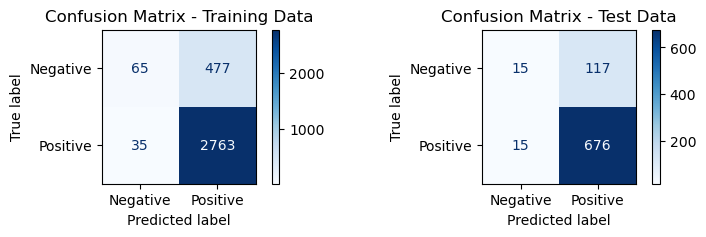

In [1151]:
# Confusion Matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log_reg_l1.predict(X_train_tfidf_w2v)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log_reg_l1.predict(X_test_tfidf_w2v)))

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ConfusionMatrixDisplay.from_estimator(best_model, X_train_tfidf_w2v, y_train, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Data')

ConfusionMatrixDisplay.from_estimator(best_model, X_test_tfidf_w2v, y_test, display_labels=['Negative', 'Positive'], cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Data')

plt.show()

In [1157]:
table.add_row(["Logistic Regression (TFIDF w2v)", best_params['C'], f"{train_auc:.2f}", f"{test_auc:.2f}"])
print(table)

+---------------------------------+--------+-----------+----------+
|              Model              | Best C | Train AUC | Test AUC |
+---------------------------------+--------+-----------+----------+
|    Logistic Regression (BoW)    |  0.1   |    0.99   |   0.89   |
|   Logistic Regression (TFIDF)   |   10   |    1.00   |   0.91   |
|  Logistic Regression (AVG W2V)  | 10000  |    0.90   |   0.85   |
| Logistic Regression (TFIDF w2v) |  1000  |    0.79   |   0.75   |
+---------------------------------+--------+-----------+----------+
